# Sun And Seasons
This notebook covers how to the earth changes across a year.

* Change ice/tree coverage based on the time of year.
* Put the sun in the correct position given a date.
* An example animation of the earth changing across a year.

## Initial Setup

In [2]:
import datetime
import os
import numpy as np
from tqdm.notebook import tqdm
import accessvis

accessvis.resolution_selection(default=1)

Low-res 2K - fast for testing
Mid-res 4K - good enough for full earth views
High res 8K - better if showing close up at country scale
Ultra-high 16K - max detail but requires a fast GPU with high memory


Dropdown(description='Detail:', options=(('Low-res 2K', 1), ('Mid-res 4K', 2), ('High-res 8K', 3), ('Ultra-hig…

As a reference, here is an image without any adjustments for time.


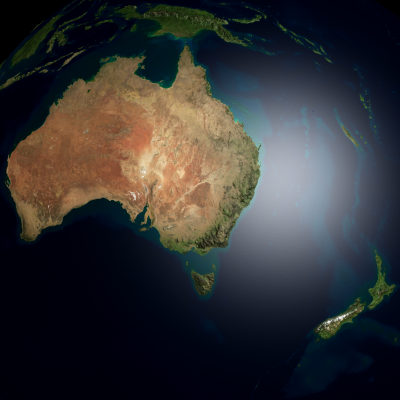

In [3]:
lv = accessvis.plot_earth(waves=True, vertical_exaggeration=15)
lv.translation(0.486, -0.75, -12.684)
lv.rotation(-137.839, -22.053, 155.435)
lv.display((400,400))

## Colour Earth Based on Time of Year

For a more true to life rendering of the earth we are using NASA's Blue Marble Next Generation dataset ([Visible Earth](https://visibleearth.nasa.gov/collection/1484/blue-marble) and [Blue Marble: Next Generation](https://neo.gsfc.nasa.gov/view.php?datasetId=BlueMarbleNG)). There are 12 monthly images from 2004. The accessvis libary grabs all the imagery at full resolution and converts to cubemap textures. These textures can then be blended to create an image for any given day of the year.

When initialising the accessvis plot, we can pass a datetime object which controls which monthly satellite data image to use.

When *blendtex* is enabled (default=True), the two month images either side of the chosen date are blended to produce a smooth transition interpolating the data for the days between the monthly image snapshots


Let's plot Australia on the 1st of January 2024.


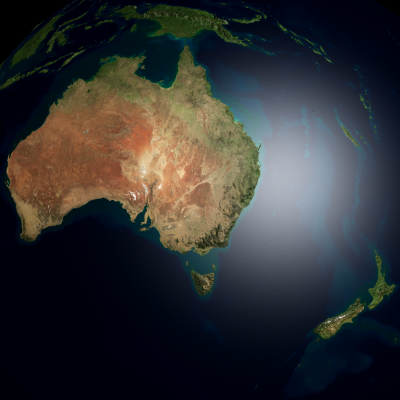

In [4]:
dt = datetime.datetime(2024, 1, 1, 12, 0, 0)
lv = accessvis.plot_earth(waves=True, when=dt, blendtex=True, vertical_exaggeration=15, sunlight=False)
lv.translation(0.486, -0.75, -12.684)
lv.rotation(-137.839, -22.053, 155.435)
lv.display((400,400))

### Adjusting for the Seasons
The update_earth_datetime() function can be used to modify the date and time in an active visualisation.

Setting the date to August 1st, if we compare with the above image, notice the greener coastal regions and snow on the high country in SE Australia and NZ.


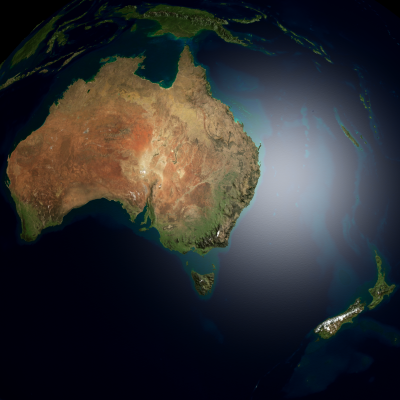

In [5]:
dt = datetime.datetime(2024, 8, 1, 12, 0, 0)
accessvis.update_earth_datetime(lv, when=dt, blendtex=True)
lv.display((400,400))

## Correcting the Sun Position
We use the `astropy` library to calculate the sun's position and earth's rotation at a given time of day for more accurate lighting.

When *sunlight* is enabled (default=False), the sun position is determined by the passed time and date, otherwise a dynamic sun light is placed directly behind the viewer so the model will always be front-illuminated regardless of how it is rotated, this is useful for interacting with the visualisation to be able to see details clearly but is obviously not a realistic lighting model.

Lets start by plotting the earth in January



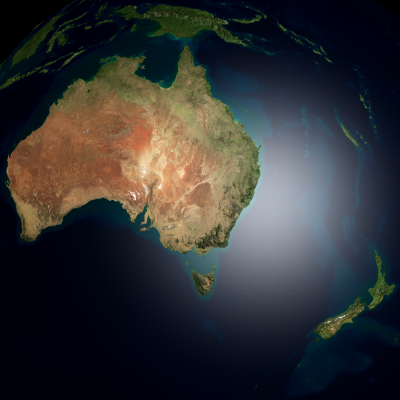

In [6]:
dt = datetime.datetime(2024, 1, 1, 12, 0, 0)
accessvis.update_earth_datetime(lv, when=dt, blendtex=False, sunlight=True)
lv.display((400,400))

Now lets do the same plot in august. You can see the sun light appears further north and is not as directly overhead as it was in January.


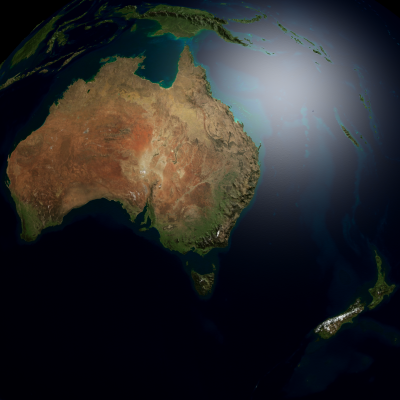

In [7]:
dt = datetime.datetime(2024, 8, 1, 12, 0, 0)
accessvis.update_earth_datetime(lv, when=dt, blendtex=False, sunlight=True)
lv.display((400,400))

Changing the time of day also causes the sun to change position.


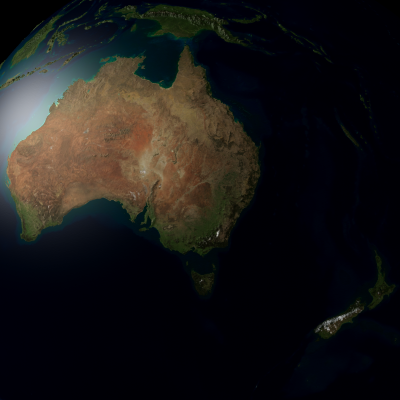

In [8]:
dt = datetime.datetime(2024, 8, 1, 18, 0, 0)
accessvis.update_earth_datetime(lv, when=dt, blendtex=False, sunlight=True)
lv.display((400,400))

### More on lighting adjustments

The function used to get the sun position is accessvis.sun_light()

It simply returns a 3D coordinate for the sun's position in our model coord system (based on Mm, millions of meters by default), which can then be passed to the "lightpos" parameter in the visualisation.

We can also verify that the sun is at the correct distance (It should be around 150 million km == 150000 million meters)

In [9]:
SP = accessvis.sun_light() # This puts the sun behind the camera 
print(SP)
print(np.linalg.norm(SP))

[ 52632.03112289  52632.03112289 131580.07780723]
151174.0


Setting the time to now


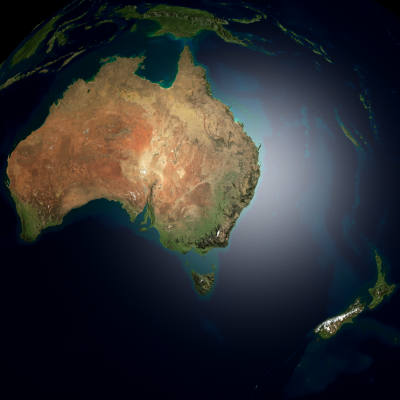

In [10]:
lv.set_properties(lightpos=accessvis.sun_light(now=True))
lv.display((400,400))

Changing the time to 8am


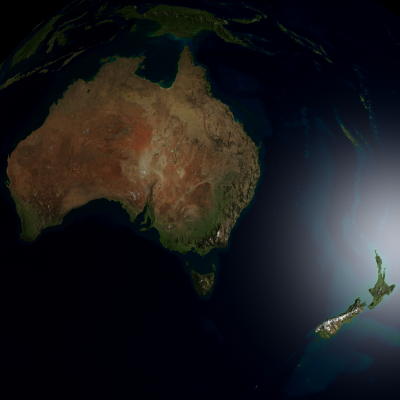

In [11]:
lp = accessvis.sun_light(hour=8)
lv.set_properties(lightpos=lp)
lv.display((400,400))

# Interactive
Notice how the sun's position is preserved, relative to the earth.

In [12]:
lv.window()

# Animation

The code below creates an animation showing the sun position and snow cover changing across a year.

In [13]:
#Shading/colour/lighting settings
lv.brightness_contrast_saturation(0.5, 0.525, 0.45)

#Setup lighting
lv.set_properties(diffuse=0.4, ambient=0.65, specular=0.4, shininess=0.045, light=[1,1,0.98,1])

#Northern hemisphere view for snow
lv.translation(0.0, 0.0, -16.75)
lv.rotation(40.775, -38.462, -21.42)

In [14]:
rinc = 0.02

filename = os.path.abspath('seasons.mp4')
print(f'Saving to {filename}')

with lv.video(filename=filename, quality=3, resolution=(1440,1440), width=1440//2, height=1080//2, params="autoplay") as v:    
    step = 4 #2
    for d in tqdm(range(0,366,step), desc='Day'):
        dt = datetime.datetime.strptime(f'04 {str(d+1).zfill(3)} 12:00', '%y %j %H:%M')
        dt = dt.replace(tzinfo=datetime.timezone.utc)
        accessvis.update_earth_datetime(lv, when=dt, sunlight=True)
        lv["title"] = '+' + dt.strftime("%d/%m/%Y")
        lv.rotate('y', rinc) #Rotate about axis too
        lv.render()

    #Final frames
    for f in range(30):
        lv.rotate('y', rinc)
        lv.render()

Saving to /home/198/mp7041/seasons.mp4


Output #0, mp4, to '/home/198/mp7041/seasons.mp4':
  Stream #0:0: Unknown: none


Day:   0%|          | 0/92 [00:00<?, ?it/s]